In [39]:
import pandas as pd
import numpy as np

from sklearn.model_selection import KFold

from sklearn.pipeline import Pipeline

from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.inspection import plot_partial_dependence, permutation_importance

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import sys
sys.path.append("..")
from source.clean import general_cleaner, drop_columns
from source.transf_category import recode_cat, make_ordinal
from source.transf_numeric import tr_numeric
import source.transf_univ as dfp
import source.utility as ut
import source.report as rp

In [40]:
df_train = pd.read_csv('../data/train.csv')

df_train['Target'] = np.log1p(df_train.SalePrice)

df_train = df_train[df_train.GrLivArea < 4500].copy().reset_index()

del df_train['SalePrice']

train_set, test_set = ut.make_test(df_train, 
                                test_size=0.2, random_state=654, 
                                strat_feat='Neighborhood')

y = train_set['Target'].copy()
del train_set['Target']

y_test = test_set['Target']
del test_set['Target']

In [41]:
numeric_lasso = Pipeline([('fs', dfp.feat_sel('numeric')),
                         ('imp', dfp.df_imputer(strategy='median')),
                         ('transf', tr_numeric(lot=False, 
                                               bedroom=False, 
                                               SF_room=False))])


cat_lasso = Pipeline([('fs', dfp.feat_sel('category')),
                     ('imp', dfp.df_imputer(strategy='most_frequent')), 
                     ('ord', make_ordinal(['BsmtQual', 'KitchenQual', 'ExterQual', 'HeatingQC'], 
                                          extra_cols=['BsmtExposure', 'BsmtCond', 'ExterCond'],
                                          include_extra='include')), 
                     ('recode', recode_cat()), 
                     ('dummies', dfp.dummify(drop_first=True))])


processing_lasso = dfp.FeatureUnion_df(transformer_list=[('cat', cat_lasso),
                                                 ('num', numeric_lasso)])

lasso_pipe = Pipeline([('gen_cl', general_cleaner()),
                       ('proc', processing_lasso),
                       ('scaler', dfp.df_scaler(method='standard')),
                       ('dropper', drop_columns(lasso=True)), 
                       ('lasso', Lasso(alpha=0.001, tol=0.005))])

In [42]:
lasso_pipe.fit(train_set.copy(), y)

Pipeline(memory=None,
         steps=[('gen_cl', general_cleaner()),
                ('proc',
                 FeatureUnion_df(n_jobs=None,
                                 transformer_list=[('cat',
                                                    Pipeline(memory=None,
                                                             steps=[('fs',
                                                                     feat_sel(dtype='category')),
                                                                    ('imp',
                                                                     df_imputer(strategy='most_frequent')),
                                                                    ('ord',
                                                                     make_ordinal(cols=['BsmtQual',
                                                                                        'KitchenQual',
                                                                                        'Ex

In [43]:
coefs = rp.get_coef(lasso_pipe)

coefs

,feat,score
22,OverallQual,0.082777
41,service_area,0.078666
29,2ndFlrSF,0.050188
28,1stFlrSF,0.049982
30,GrLivArea,0.048386
3,Neighborhood,0.044160
23,OverallCond,0.043481
24,YearBuilt,0.031764
21,LotArea,0.028605
27,BsmtUnfSF,-0.025204


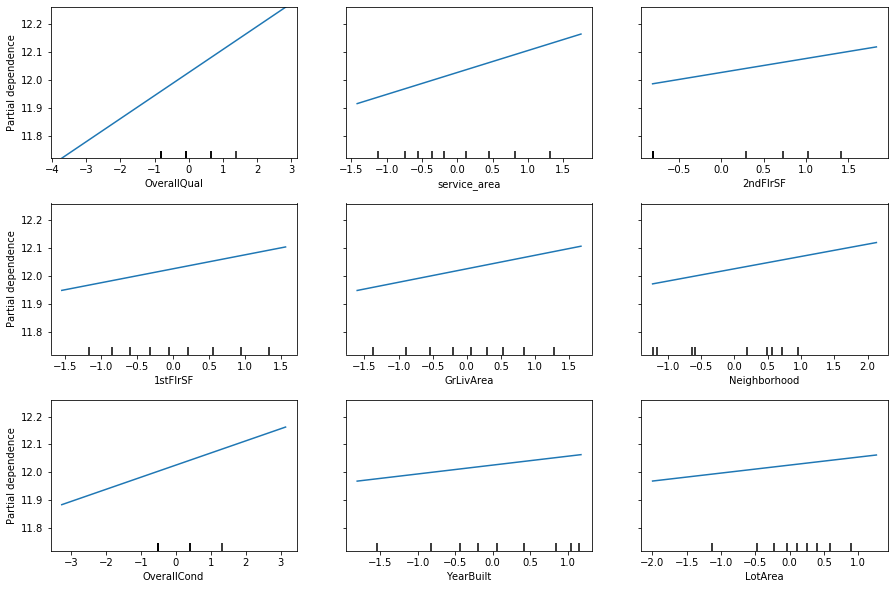

In [10]:
features = coefs.head(9).feat.values
proc = Pipeline([('gen_cl', general_cleaner()),
                       ('proc', processing_lasso),
                       ('scaler', dfp.df_scaler(method='standard')),
                       ('dropper', drop_columns(lasso=True))])
tmp = proc.fit_transform(train_set.copy(), y)
ls_tm = Lasso(alpha=0.001, tol=0.005)
ls_tm.fit(tmp, y)

fig, ax = plt.subplots(3,3, figsize=(15,10))

plot_partial_dependence(ls_tm, tmp, features, ax=ax,
                        n_jobs=-1, grid_resolution=20)

fig.subplots_adjust(hspace=0.3)

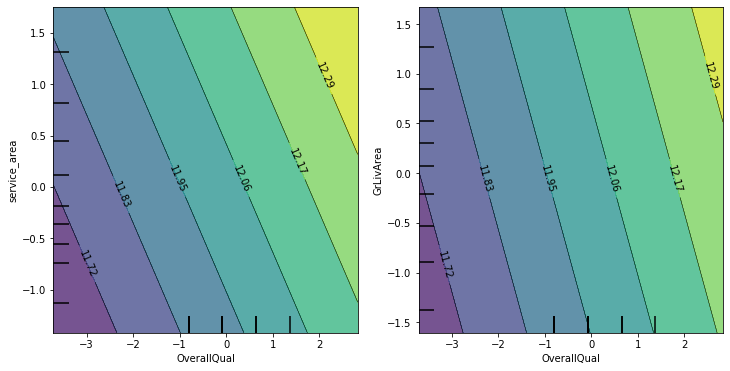

In [18]:
features = [('OverallQual', 'service_area'), ('OverallQual', 'GrLivArea')]
proc = Pipeline([('gen_cl', general_cleaner()),
                       ('proc', processing_lasso),
                       ('scaler', dfp.df_scaler(method='standard')),
                       ('dropper', drop_columns(lasso=True))])
tmp = proc.fit_transform(train_set.copy(), y)
ls_tm = Lasso(alpha=0.001, tol=0.005)
ls_tm.fit(tmp, y)

fig, ax = plt.subplots(1,2, figsize=(12,6))

plot_partial_dependence(ls_tm, tmp, features, ax=ax,
                        n_jobs=-1, grid_resolution=20)

fig.subplots_adjust(hspace=0.3)

In [44]:
numeric_forest = Pipeline([('fs', dfp.feat_sel('numeric')),
                         ('imp', dfp.df_imputer(strategy='median')),
                         ('transf', tr_numeric(SF_room=False,
                                               bedroom=False, 
                                               lot=False))])


cat_forest = Pipeline([('fs', dfp.feat_sel('category')),
                     ('imp', dfp.df_imputer(strategy='most_frequent')), 
                     ('ord', make_ordinal(['BsmtQual', 'KitchenQual', 'ExterQual', 'HeatingQC'], 
                                          extra_cols=['BsmtExposure', 'BsmtCond', 'ExterCond'],
                                          include_extra='include')), 
                     ('recode', recode_cat()), 
                     ('dummies', dfp.dummify(drop_first=True))])


processing_forest = dfp.FeatureUnion_df(transformer_list=[('cat', cat_forest),
                                                 ('num', numeric_forest)])

forest_pipe = Pipeline([('gen_cl', general_cleaner()),
                       ('proc', processing_forest),
                       ('scaler', dfp.df_scaler(method='robust')),
                       ('dropper', drop_columns(forest=True)), 
                       ('forest', RandomForestRegressor(n_estimators=1500, max_depth=30, 
                                                        max_features='sqrt',
                                                        n_jobs=-1, random_state=32))])

In [45]:
forest_pipe.fit(train_set.copy(), y)

Pipeline(memory=None,
         steps=[('gen_cl', general_cleaner()),
                ('proc',
                 FeatureUnion_df(n_jobs=None,
                                 transformer_list=[('cat',
                                                    Pipeline(memory=None,
                                                             steps=[('fs',
                                                                     feat_sel(dtype='category')),
                                                                    ('imp',
                                                                     df_imputer(strategy='most_frequent')),
                                                                    ('ord',
                                                                     make_ordinal(cols=['BsmtQual',
                                                                                        'KitchenQual',
                                                                                        'Ex

In [46]:
coefs = rp.get_feature_importance(forest_pipe)

coefs

,feat,score
29,OverallQual,0.123803
37,GrLivArea,0.100539
49,service_area,0.095976
4,Neighborhood,0.089066
5,ExterQual,0.059408
8,KitchenQual,0.054377
42,GarageCars,0.044922
31,YearBuilt,0.044300
48,total_bath,0.044070
35,1stFlrSF,0.042777


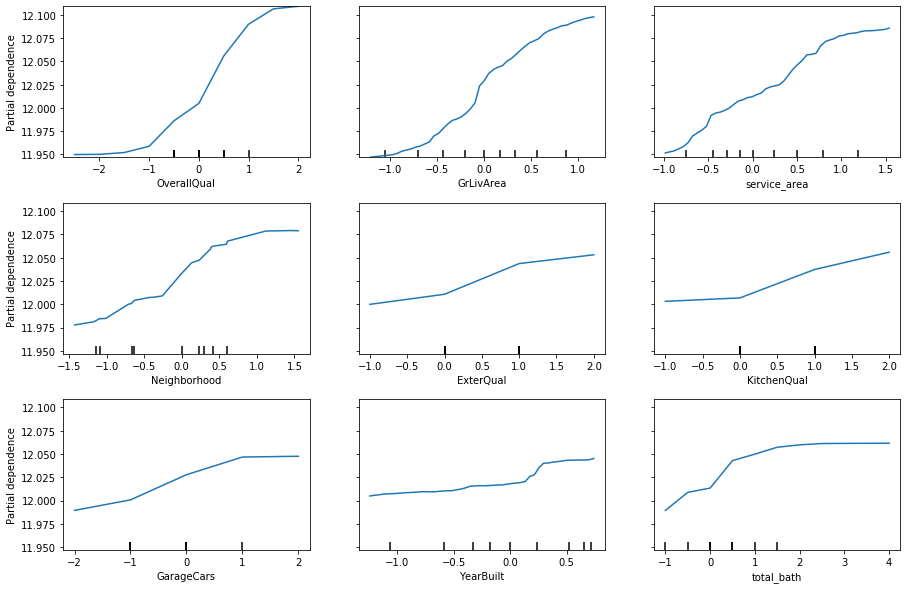

In [33]:
features = coefs.head(9).feat.values
proc = Pipeline([('gen_cl', general_cleaner()),
                   ('proc', processing_forest),
                   ('scaler', dfp.df_scaler(method='robust')),
                   ('dropper', drop_columns(forest=True))])
tmp = proc.fit_transform(train_set.copy(), y)
ls_tm = RandomForestRegressor(n_estimators=1500, max_depth=30, 
                                                        max_features='sqrt',
                                                        n_jobs=-1, random_state=32)
ls_tm.fit(tmp, y)

fig, ax = plt.subplots(3,3, figsize=(15,10))

plot_partial_dependence(ls_tm, tmp, features, ax=ax,
                        n_jobs=-1, grid_resolution=50)

fig.subplots_adjust(hspace=0.3)

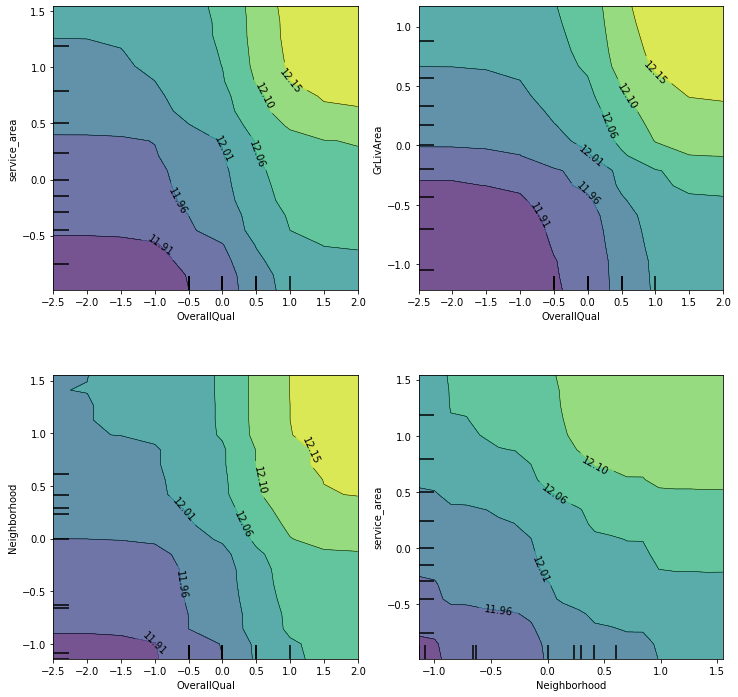

In [34]:
features = [('OverallQual', 'service_area'), ('OverallQual', 'GrLivArea'), 
            ('OverallQual', 'Neighborhood'), ('Neighborhood', 'service_area')]

fig, ax = plt.subplots(2,2, figsize=(12,12))

plot_partial_dependence(ls_tm, tmp, features, ax=ax,
                        n_jobs=-1, grid_resolution=20)

fig.subplots_adjust(hspace=0.3)

In [48]:
result = permutation_importance(ls_tm, tmp, y, n_repeats=20,
                                random_state=42, n_jobs=-1)

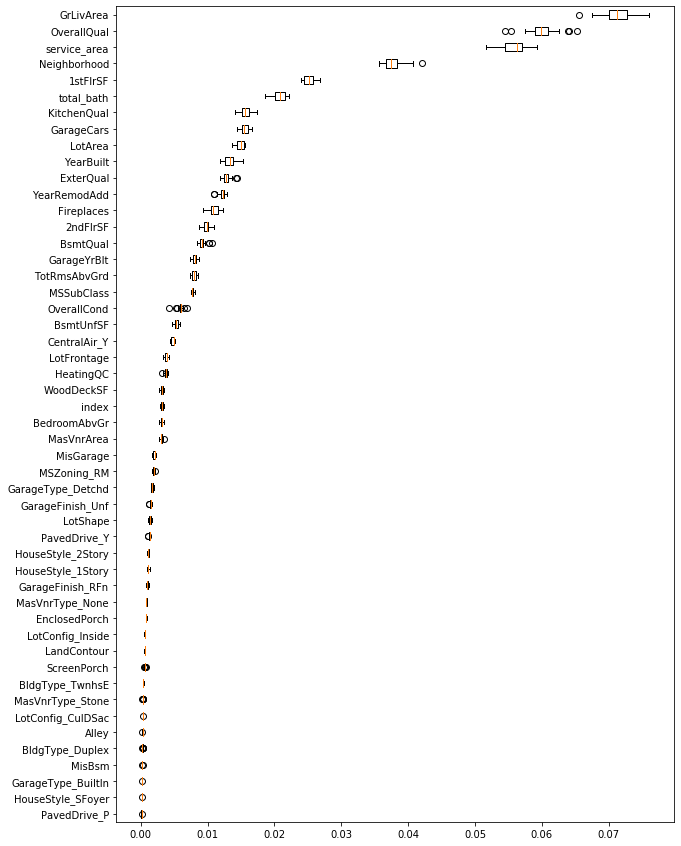

In [50]:
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(10, 15))
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=tmp.columns[sorted_idx])
plt.show()